In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import os
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
torch.manual_seed(3407)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/lstm_data/data.csv')
threshold = 0.4256
df['logic']=df['logic'].apply(lambda x: 1 if x > threshold else 0)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [ ]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [ ]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [ ]:
vocab_size = len(tokenizer.get_vocab())
print(vocab_size)

33


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)

In [ ]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [ ]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [ ]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [ ]:
y = scores

In [ ]:
X = torch.stack((pep_input_ids,mhc_input_ids,pep_attention_mask,mhc_attention_mask),dim=1)
y = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1],X_val[:,2],X_val[:,3], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

    def forward(self, x, lengths=None):
        if lengths is not None:
            # Sort sequences by length in descending order
            sorted_lengths, sorted_indices = torch.sort(lengths, descending=True)
            x_sorted = x[sorted_indices]

            # Pack padded sequence
            packed_x = pack_padded_sequence(x_sorted, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
            packed_output, (hidden, cell) = self.lstm(packed_x)

            # Unpack and reorder to original sequence order
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
            unsorted_indices = sorted_indices.argsort()
            output = output[unsorted_indices]
        else:
            output, (hidden, cell) = self.lstm(x)

        return output  # (batch_size, seq_len, hidden_dim)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value, key_padding_mask=None):
        attn_output, attn_weights = self.multihead_attn(
            query=query,
            key=key,
            value=value,
            key_padding_mask=key_padding_mask
        )
        attn_output = self.norm1(attn_output + query)
        ffn_output = self.ffn(attn_output)
        output = self.norm2(ffn_output + attn_output)
        return output, attn_weights

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers,
                 vocab_size, dropout=0.1):
        super().__init__()
        self.embed_pep = nn.Sequential(
            nn.Embedding(vocab_size, input_dim),
            nn.LayerNorm(input_dim))

        self.embed_mhc = nn.Sequential(
            nn.Embedding(vocab_size, input_dim),
            nn.LayerNorm(input_dim)
        )

        self.encoder_pep = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)
        self.encoder_mhc = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)

        self.cross_attention = CrossAttentionLayer(hidden_dim, num_heads, dropout)

        self.last_layer = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, pep_cls, mhc_cls):
        # Embed sequences
        pep_embedded = self.embed_pep(pep_cls)  # (batch_size, pep_len, input_dim)
        mhc_embedded = self.embed_mhc(mhc_cls)  # (batch_size, mhc_len, input_dim)

        # Calculate sequence lengths (assuming 0 is padding index)
        pep_lengths = (pep_cls != 1).sum(dim=1)
        mhc_lengths = (mhc_cls != 1).sum(dim=1)

        # Encode sequences
        pep_refined = self.encoder_pep(pep_embedded, pep_lengths)  # (batch, pep_len, hidden_dim)
        mhc_refined = self.encoder_mhc(mhc_embedded, mhc_lengths)  # (batch, mhc_len, hidden_dim)

        # Create padding mask for MHC sequences
        mhc_padding_mask = (mhc_cls == 1)  # (batch_size, mhc_len)
        mhc_padding_mask = mhc_padding_mask[:, :mhc_refined.shape[1]]

        # Apply cross-attention
        cross_output, attn_weights = self.cross_attention(
            query=pep_refined,
            key=mhc_refined,
            value=mhc_refined,
            key_padding_mask=mhc_padding_mask
        )  # (batch_size, pep_len, hidden_dim)

        # Aggregate cross-attention output
        cross_aggregated = cross_output.mean(dim=1)  # (batch_size, hidden_dim)

        # Final prediction
        x = self.last_layer(cross_aggregated)

        return x, attn_weights

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
vocab_size= 33
hidden_dim = input_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.3
model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
epochs = 200

In [ ]:
patience = 5
best_val_auroc = 0
patience_counter = 0
save_path = '/content/drive/MyDrive/lstm_data/model/classification.pth'
train_losses = []
val_losses = []
train_auroc_list = []
val_auroc_list = []
train_f1_list = []
val_f1_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []
best_val_loss = float('inf')


for epoch in range(epochs):
    #train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
        pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )
        optimizer.zero_grad()
        outputs,_ = model(pep_ids, mhc_ids)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds).numpy()
    total_train_labels = torch.cat(total_train_labels).numpy()
    train_auroc = roc_auc_score(total_train_labels, total_train_preds)
    train_f1 = f1_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_precision = precision_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_recall = recall_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)

    train_auroc_list.append(train_auroc)
    train_f1_list.append(train_f1)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)

    #val loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )
            outputs,_ = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            val_loss += loss.item()
            total_val_preds.append(torch.sigmoid(outputs).cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    total_val_preds = torch.cat(total_val_preds).numpy()
    total_val_labels = torch.cat(total_val_labels).numpy()
    val_auroc = roc_auc_score(total_val_labels, total_val_preds)
    val_f1 = f1_score(total_val_labels, total_val_preds > 0.4256)
    val_precision = precision_score(total_val_labels, total_val_preds > 0.4256)
    val_recall = recall_score(total_val_labels, total_val_preds > 0.4256)

    val_auroc_list.append(val_auroc)
    val_f1_list.append(val_f1)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    print(f"Epoch {epoch+1},Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    #early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print("Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break



Epoch 1,Train Loss: 0.5686, Val Loss: 0.5501, AUROC: 0.8002, F1: 0.6265, Precision: 0.7445, Recall: 0.5408
Model saved!
Epoch 2,Train Loss: 0.5127, Val Loss: 0.5047, AUROC: 0.8295, F1: 0.7190, Precision: 0.6560, Recall: 0.7954
Model saved!
Epoch 3,Train Loss: 0.4845, Val Loss: 0.4853, AUROC: 0.8395, F1: 0.7156, Precision: 0.7213, Recall: 0.7099
Model saved!
Epoch 4,Train Loss: 0.4616, Val Loss: 0.4723, AUROC: 0.8490, F1: 0.7361, Precision: 0.7028, Recall: 0.7726
Model saved!
Epoch 5,Train Loss: 0.4429, Val Loss: 0.4617, AUROC: 0.8571, F1: 0.7396, Precision: 0.7287, Recall: 0.7509
Model saved!
Epoch 6,Train Loss: 0.4290, Val Loss: 0.4641, AUROC: 0.8611, F1: 0.7440, Precision: 0.7327, Recall: 0.7556
Epoch 7,Train Loss: 0.4146, Val Loss: 0.4686, AUROC: 0.8609, F1: 0.7411, Precision: 0.7380, Recall: 0.7441
Epoch 8,Train Loss: 0.4032, Val Loss: 0.4534, AUROC: 0.8669, F1: 0.7556, Precision: 0.7087, Recall: 0.8091
Model saved!
Epoch 9,Train Loss: 0.3898, Val Loss: 0.4623, AUROC: 0.8683, F1: 0

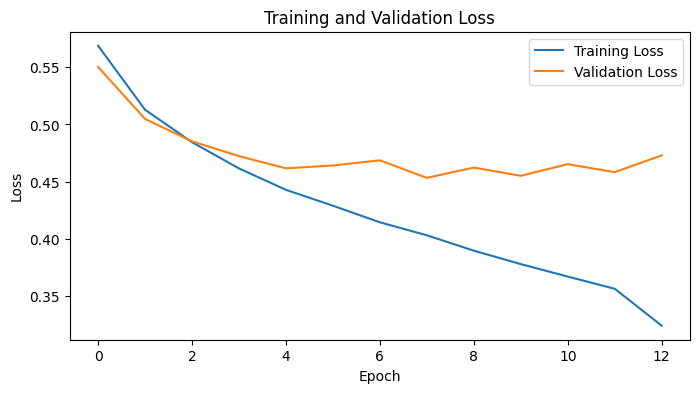

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
save_path =  '/content/drive/MyDrive/lstm_data/model/classification.pth'
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix)

model.load_state_dict(torch.load(save_path,weights_only=True))
model.eval()
total_test_preds = []
total_test_labels = []
test_loss = 0

with torch.no_grad():
    for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in test_loader:
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        outputs,_ = model(pep_ids, mhc_ids)
        loss = criterion(outputs.squeeze(), scores)
        test_loss += loss.item()
        total_test_preds.append(torch.sigmoid(outputs).cpu())
        total_test_labels.append(scores.cpu())

test_loss /= len(test_loader)
total_test_preds = torch.cat(total_test_preds).numpy()
total_test_labels = torch.cat(total_test_labels).numpy()
threshold = 0.4256
binary_preds = (total_test_preds >= threshold).astype(int)
test_auroc = roc_auc_score(total_test_labels, total_test_preds)
test_f1 = f1_score(total_test_labels, binary_preds)
test_precision = precision_score(total_test_labels, binary_preds)
test_recall = recall_score(total_test_labels, binary_preds)
print(f"Test Loss: {test_loss:.4f}, AUROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Test Loss: 0.4409, AUROC: 0.8736, F1: 0.7603, Precision: 0.7150, Recall: 0.8117


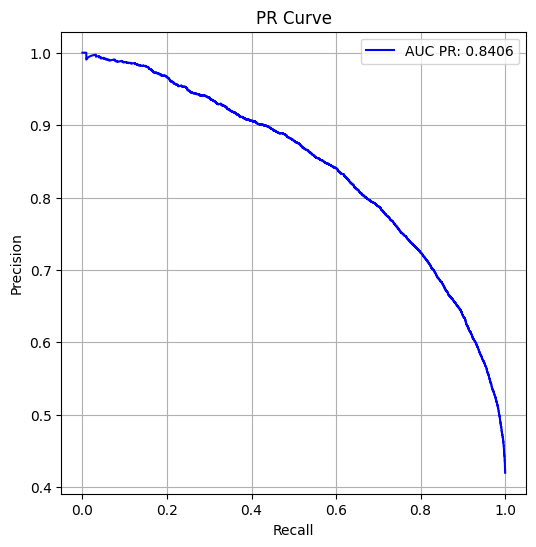

In [ ]:
precision, recall, _ = precision_recall_curve(total_test_labels, total_test_preds)
pr_auc = auc(recall, precision)


plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'AUC PR: {pr_auc:.4f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

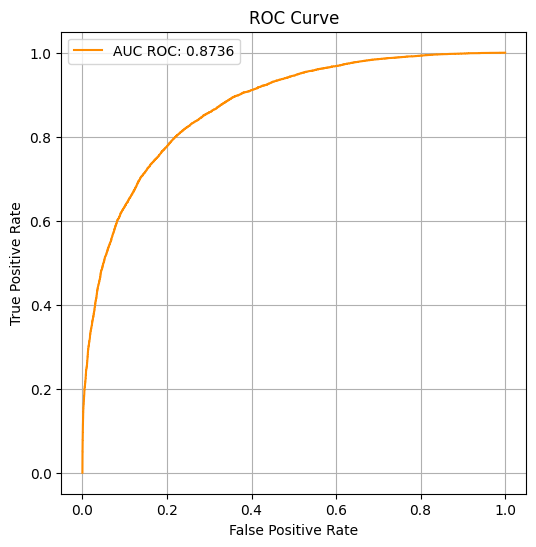

In [ ]:
fpr, tpr, _ = roc_curve(total_test_labels, total_test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC ROC: {roc_auc:.4f}', color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

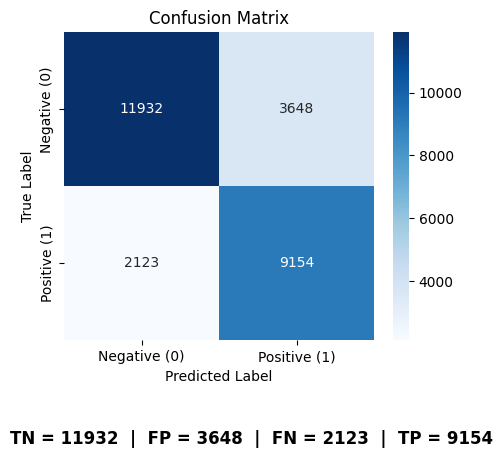

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(total_test_labels, binary_preds)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.figtext(0.5, -0.15, f'TN = {tn}  |  FP = {fp}  |  FN = {fn}  |  TP = {tp}',ha='center', fontsize=12, weight='bold')

plt.show()


# Kfold

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold
import os



k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 128
epochs = 200
patience = 6
save_dir = '/content/drive/MyDrive/lstm_data/kfold'


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
test_dataset = TensorDataset(X_test[: ,0],X_test[:,1],X_test[:,2],X_test[:,3], y_test)

In [ ]:
batch_size=64

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
vocab_size= 33
hidden_dim = input_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.3
model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
epochs = 200

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(X_train)))):
    print(f"\n========== Starting Fold {fold + 1}/{k_folds} ==========")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

    #model init
    model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,weight_decay=1e-05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = torch.nn.BCEWithLogitsLoss()

    #early stop params
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    threshold = 0.4256
    save_path = os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth")

    for epoch in range(epochs):
        #train loop
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs,_ = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        total_train_preds = torch.cat(total_train_preds).numpy()
        total_train_labels = torch.cat(total_train_labels).numpy()
        train_auroc = roc_auc_score(total_train_labels, total_train_preds)
        train_f1 = f1_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_precision = precision_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_recall = recall_score(total_train_labels, total_train_preds > threshold, zero_division=0)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, AUROC: {train_auroc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

        #val loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
                pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
                outputs,_ = model(pep_ids, mhc_ids)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(torch.sigmoid(outputs).cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        # scheduler.step(val_loss)
        total_val_preds = torch.cat(total_val_preds).numpy()
        total_val_labels = torch.cat(total_val_labels).numpy()
        val_auroc = roc_auc_score(total_val_labels, total_val_preds)
        val_f1 = f1_score(total_val_labels, total_val_preds > threshold)
        val_precision = precision_score(total_val_labels, total_val_preds > threshold)
        val_recall = recall_score(total_val_labels, total_val_preds > threshold)

        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        #earlystop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved for Fold {fold+1} with Val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val auroc: {best_val_loss:.4f}")
                break

    print(f"========== Completed Fold {fold + 1}/{k_folds} ==========")


========== Starting Fold 1/5 ==========
Epoch 1, Train Loss: 0.5637, AUROC: 0.7663, F1: 0.6495, Precision: 0.6205, Recall: 0.6815
Epoch 1, Val Loss: 0.5303, AUROC: 0.8033, F1: 0.6941, Precision: 0.6440, Recall: 0.7527
Best model saved for Fold 1 with Val loss: 0.5303
Epoch 2, Train Loss: 0.5147, AUROC: 0.8147, F1: 0.6960, Precision: 0.6743, Recall: 0.7191
Epoch 2, Val Loss: 0.5050, AUROC: 0.8237, F1: 0.6960, Precision: 0.7141, Recall: 0.6788
Best model saved for Fold 1 with Val loss: 0.5050
Epoch 3, Train Loss: 0.4857, AUROC: 0.8385, F1: 0.7201, Precision: 0.6980, Recall: 0.7436
Epoch 3, Val Loss: 0.4964, AUROC: 0.8368, F1: 0.7082, Precision: 0.7425, Recall: 0.6770
Best model saved for Fold 1 with Val loss: 0.4964
Epoch 4, Train Loss: 0.4661, AUROC: 0.8530, F1: 0.7366, Precision: 0.7104, Recall: 0.7648
Epoch 4, Val Loss: 0.4740, AUROC: 0.8483, F1: 0.7328, Precision: 0.7183, Recall: 0.7479
Best model saved for Fold 1 with Val loss: 0.4740
Epoch 5, Train Loss: 0.4486, AUROC: 0.8655, F1:

In [ ]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, confusion_matrix,auc
import seaborn as sns

test_dataset = TensorDataset(X_test[:, 0], X_test[:, 1], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

save_dir = "/content/drive/MyDrive/lstm_data/kfold"
k_folds = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
for fold in range(k_folds):
    model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
    model.to(device)
    model_path = os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth")
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    models.append(model)

total_preds = []
total_labels = []
total_loss = 0
criterion = nn.BCEWithLogitsLoss()
threshold = 0.4256
total_loss = 0
total_preds = []
total_labels = []

with torch.no_grad():
    for pep_ids, mhc_ids, scores in test_loader:
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)

        outputs = torch.zeros_like(scores, dtype=torch.float32).to(device)
        for model in models:
            out,_= model(pep_ids, mhc_ids)
            outputs +=out.squeeze()
        outputs /= len(models)

        loss = criterion(outputs, scores)
        total_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().numpy()

        total_preds.append(probs)
        total_labels.append(scores.cpu().numpy())

total_preds = np.concatenate(total_preds)
total_labels = np.concatenate(total_labels)


test_loss = total_loss / len(test_loader)
test_auroc = roc_auc_score(total_labels, total_preds)
test_f1 = f1_score(total_labels, total_preds > threshold)
test_precision = precision_score(total_labels, total_preds > threshold)
test_recall = recall_score(total_labels, total_preds > threshold)

print("Test Metrics:")
print(f"Loss: {test_loss:.4f}, AUC ROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")



Test Metrics:
Loss: 0.4107, AUC ROC: 0.8889, F1: 0.7736, Precision: 0.7502, Recall: 0.7985


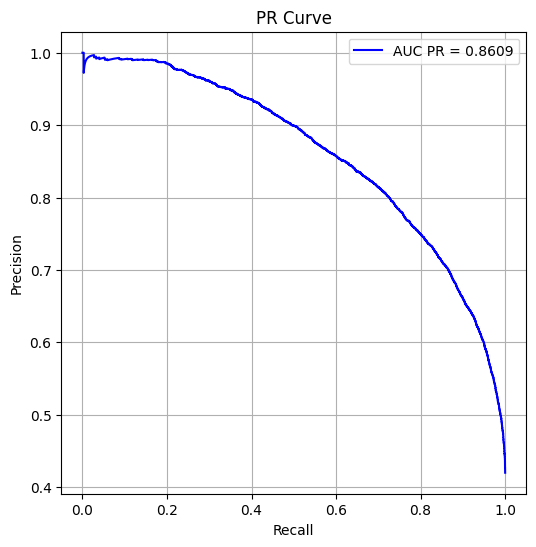

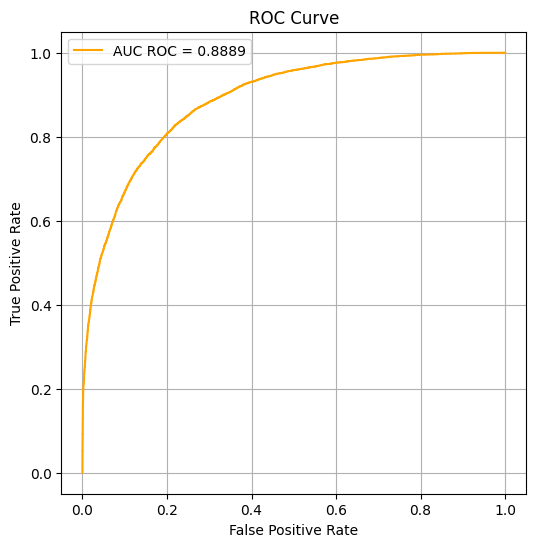

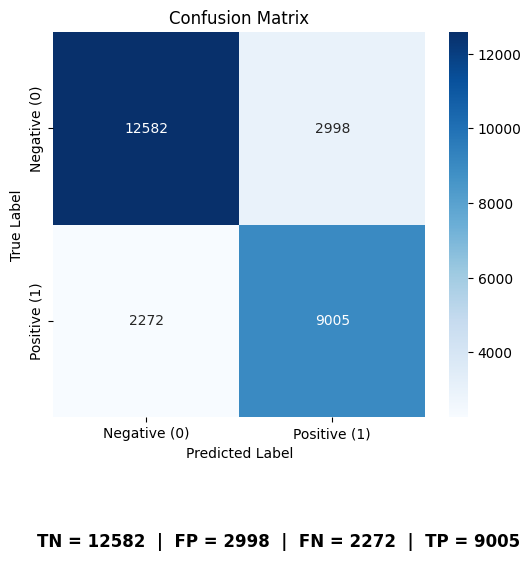

In [ ]:
precision, recall, _ = precision_recall_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
test_pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', label=f'AUC PR = {test_pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend()
plt.grid()
plt.show()

fpr, tpr, _ = roc_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', label=f'AUC ROC = {test_auroc:.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

conf_matrix = confusion_matrix(total_labels, total_preds > threshold)
tn, fp, fn, tp = conf_matrix.ravel()
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.figtext(0.5, -0.15, f'TN = {tn}  |  FP = {fp}  |  FN = {fn}  |  TP = {tp}',ha='center', fontsize=12, weight='bold')
plt.show()
